# Introduction
-------------------------
In this notebook, we present a step-by-step work progress in building a first-order Causal Vector Auto-Regression, CVAR(1), model on the international stock market dataset. At the end, we also showcase how the model can be built in one-step with the ```CVAR()``` function (once the desired ordering and the junction tree structure is found). 

In [1]:
# for data processing and matrix computations
import numpy as np
import pandas as pd

# for graph-related features
import networkx as nx

# for computing p-values for hypothesis testing
from scipy import stats 

# for general plotting
import matplotlib.pyplot as plt

from Causal_VAR import * 

# Preparing Data

In [2]:
# load raw data
X_raw = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00247/data_akbilgic.xlsx", header=1)
# select the desired columns
X= X_raw.reindex(columns = ["BOVESPA", "SP", "FTSE", "DAX", "EU", "EM",
                              "ISE.1", "NIKKEI"])
# relabel varaibles with shorter names
X = X.rename(columns = {"BOVESPA": "BVSP", "ISE.1" : "ISE", "NIKKEI": "NIK"})

X.head() # display first 5 rows

BVSP        SP      FTSE  ...        EM       ISE       NIK
0  0.031190 -0.004679  0.003894  ...  0.028524  0.038376  0.000000
1  0.018920  0.007787  0.012866  ...  0.008773  0.031813  0.004162
2 -0.035899 -0.030469 -0.028735  ... -0.020015 -0.026353  0.017293
3  0.028283  0.003391 -0.000466  ... -0.019424 -0.084716 -0.040061
4 -0.009764 -0.021533 -0.012710  ... -0.007802  0.009658 -0.004474

[5 rows x 8 columns]

# Hypothsis Test and Undirected Skeleton

**Summary: For Causal VAR(1) model, we conduct deviance test on the partial correlation coefficients based on C(1|0)^{-1} to find an undirected, chordal graph G. G will serve as the skeleton of a possible directed acyclic graph (DAG) that prescribes the causal relationship between comtemporaneous variables in the later steps.**

1. Use ```inv_cond_cov()``` to find the inverse conditional covariance matrix C(1|0)^{-1}, which is the upper left dxd block of K, the inverse of the Toeplitz block covariance matrix.

In [3]:
C_1_given_0 = inv_cond_cov(data=X, p=1, keep_label=True)
C_1_given_0 # display the matrix

8


BVSP            SP  ...          ISE           NIK
BVSP  13502.055885  -7158.979553  ...  1055.524246   2085.852382
SP    -7158.979553  15305.440523  ...  -775.385666   -345.307631
FTSE   1699.653134  -2461.702313  ...  1343.023853    802.817100
DAX    2275.722213  -5086.584768  ...  1277.271139    174.347336
EU    -3318.097330   -476.931361  ... -5890.545388    271.255019
EM   -13200.524372   4302.018810  ... -5296.566750  -9148.418864
ISE    1055.524246   -775.385666  ...  5860.338493     43.424169
NIK    2085.852382   -345.307631  ...    43.424169  10277.354137

[8 rows x 8 columns]

2. Apply ```partial_cor()``` on C(1|0)^{-1} to find the particial correlation coefficients between contemporaneous variables (ceteris paribus).

In [4]:
rr = partial_cor(C_1_given_0, keep_label=True)
rr # display the matrix

BVSP        SP      FTSE  ...        EM       ISE       NIK
BVSP       NaN  0.497999 -0.055571  ...  0.546030 -0.118661 -0.177069
SP    0.497999       NaN  0.075596  ... -0.167138  0.081872  0.027532
FTSE -0.055571  0.075596       NaN  ...  0.097921 -0.066651 -0.030086
DAX  -0.095423  0.200325 -0.210273  ...  0.048012 -0.081293 -0.008379
EU    0.076031  0.010264  0.749605  ...  0.029383  0.204879 -0.007124
EM    0.546030 -0.167138  0.097921  ...       NaN  0.332551  0.433741
ISE  -0.118661  0.081872 -0.066651  ...  0.332551       NaN -0.005595
NIK  -0.177069  0.027532 -0.030086  ...  0.433741 -0.005595       NaN

[8 rows x 8 columns]

3. Perform hypothesis testing on the partial coefficients to build the adjacency matrix of the graph. The result of the test determines the existence of an edge between any two variables. 

Note: The graph has to be chordal/decomposable (please refer to the paper/references).

In this example, we use a cuttoff r* = 0.04, which is equivalent to setting alpha = 0.02.

In [5]:
G_mat = (abs(rr) > 0.04).astype(int)
G_mat

BVSP  SP  FTSE  DAX  EU  EM  ISE  NIK
BVSP     0   1     1    1   1   1    1    1
SP       1   0     1    1   0   1    1    0
FTSE     1   1     0    1   1   1    1    0
DAX      1   1     1    0   1   1    1    0
EU       1   0     1    1   0   0    1    0
EM       1   1     1    1   0   0    1    1
ISE      1   1     1    1   1   1    0    0
NIK      1   0     0    0   0   1    0    0

We could use the NetworkX (nx) package to analyze the graph to make sure that it has the desired properties. Below are some simple examples:

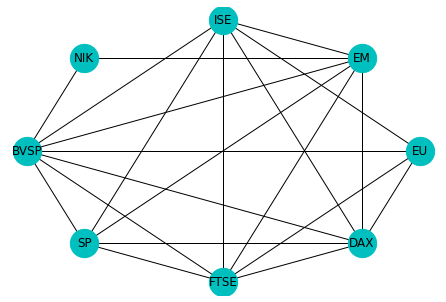

is_chordal? True


In [6]:
# Convert adjacency matrix to a Graph object
G = nx.Graph(G_mat)
# draw the graph 
nx.draw_shell(G, node_size= 800,  node_color='c', with_labels = True)
plt.show()

# check if the graph is chordal
print("is_chordal?", nx.is_chordal(G))

# Finding a DAG and RZP via MCS

**Summary: Given a chordal graph, we may reorder its adjacency matrix to find a reducible zero pattern using maximal carnalidy serach (MCS); in such an ordering, the undirected skeleton is markov-equivalent to the directed graph.**

1. We may visually inspect the (chordal) graph or use MCS to find a topological ordering with RZP. Our module supplies two versions of the MCS algorithm (called ```max_card_order()``` and ```max_card_order_v1()```) for this step.

In [7]:
# max_card_order_v1() allows users to break-ties manually.
# uncomment the line below to see how it works:
# ---------------------------------------------
#max_card_order_v1(G, start_node='SP') 

# ---------------------------------------------
# When prompted to break-ties enter in order: 
#       DAX, FTSE, BVSP, EM
# output: ['NIK', 'EU', 'ISE', 'EM', 'BVSP', 'FTSE', 'DAX', 'SP']

# This is the preferred ordering that best fits the orginal paper on this 
## stock market dataset.
preferred_order = ['NIK', 'EU', 'ISE', 'EM', 'BVSP','DAX', 'FTSE', 'SP']

2. Reorder the adjacency matrix based on the preferred ordering.

To do so, we may simply convert the graph to an adjacency list (which actually a Python dict) and reorder the adjaency "list" accordingly; then convert the it back to a Graph object, and lastly to the reordered adjacency matrix. 

In [8]:
# convert to adjacency list (dict)
G_dict = nx.to_dict_of_lists(G)
# back to a Graph object
G_reordered = nx.Graph({node : G_dict[node] for node in preferred_order})
# and, finally, restore the adjacency matrix
G_reordered_mat = nx.to_pandas_adjacency(G_reordered, dtype=int)
G_reordered_mat # display the matrix 

NIK  EU  ISE  EM  BVSP  DAX  FTSE  SP
NIK     0   0    0   1     1    0     0   0
EU      0   0    1   0     1    1     1   0
ISE     0   1    0   1     1    1     1   1
EM      1   0    1   0     1    1     1   1
BVSP    1   1    1   1     0    1     1   1
DAX     0   1    1   1     1    0     1   1
FTSE    0   1    1   1     1    1     0   1
SP      0   0    1   1     1    1     1   0

Aside: we may verify if this adjaency matrix actually has RZP using ```check_RZP()``` provided in our module.

In [9]:
check_RZP(G_reordered_mat)

True

Aside(2): Notice that the original adjacency matrix does NOT have RZP.

In [10]:
check_RZP(G_mat)

False

# Covariance Selection via Junction Tree

**Summary: With RZP in the adjacency matrix of the graph, we may reorder our data accordingly and then apply covariance selection (via Junction Tree) to find the concetration matrix K for a restricted VAR(1) model respective to the graph.**

1. Reorder the sample matrix

In [11]:
X_reordered = X.reindex(columns = preferred_order)
X_reordered.head() 

NIK        EU       ISE  ...       DAX      FTSE        SP
0  0.000000  0.012698  0.038376  ...  0.002193  0.003894 -0.004679
1  0.004162  0.011341  0.031813  ...  0.008455  0.012866  0.007787
2  0.017293 -0.017073 -0.026353  ... -0.017833 -0.028735 -0.030469
3 -0.040061 -0.005561 -0.084716  ... -0.011726 -0.000466  0.003391
4 -0.004474 -0.010989  0.009658  ... -0.019873 -0.012710 -0.021533

[5 rows x 8 columns]

2. Find a junction tree structure from the chordal graph. For simplicity, we use the existing JT algorithm in NetworkX in this example.  

In [12]:
JT = nx.junction_tree(G_reordered)
# JT.nodes(data='type') # uncomment to display the nodes in JT with "type" info.

By configuration, we need to convert the junction tree into a dict of list of tuples. 

(We may also manually type-in a junction tree structure in this format)

In [13]:
# initialize the dictionary object
JT_dct = {
    'cliques':[],
    'separators': []
}

# 
for node, nodeType in JT.nodes(data='type'):
  if nodeType == 'clique':
    JT_dct['cliques'].append(node)
  else:
    JT_dct['separators'].append(node)

In [14]:
JT_dct

{'cliques': [('BVSP', 'EM', 'NIK'),
  ('BVSP', 'DAX', 'EM', 'FTSE', 'ISE', 'SP'),
  ('BVSP', 'DAX', 'EU', 'FTSE', 'ISE')],
 'separators': [('BVSP', 'EM'), ('BVSP', 'DAX', 'FTSE', 'ISE')]}

3. Finally, run the ```cov_selection()``` on the reordered data.

In [15]:
K_hat = cov_selection(X_reordered, 1, JT_dct, keep_label=True)
K_hat # display the result

NIK             EU  ...        FTSE-1          SP-1
NIK     10223.127901       0.000000  ...  -1171.482271  -2721.610197
EU          0.000000  142751.044704  ... -13839.065683     30.921020
ISE         0.000000   -6004.310120  ...    649.227471   -827.980317
EM      -8375.874592       0.000000  ...   3601.387013   -292.275912
BVSP     2126.523840   -3845.846604  ...    327.817005   -347.371855
DAX         0.000000  -53988.358950  ...   3436.506432   -932.131562
FTSE        0.000000  -75617.001401  ...   8556.411878   -956.168949
SP          0.000000       0.000000  ...  -2209.656315   3342.075929
NIK-1    1851.409068   -1869.112399  ...   1602.842211   -847.509298
EU-1    -1837.598243   17320.847068  ... -73392.918228   -517.251927
ISE-1    -874.794810    -651.448276  ...   1313.637981    101.687198
EM-1      860.769579    4333.721567  ...  -4855.062489   3611.498576
BVSP-1    755.761199   -1861.738477  ...   1213.154978  -6552.701495
DAX-1     -59.007932   -5919.388968  ...  11232.166165  -4840.108424
FTSE-1  -1171.482271  -13839.065683  ...  68572.070064  -2183.575131
SP-1    -2721.610197      30.921020  ...  -2183.575131  16525.455516

[16 rows x 16 columns]

# Block LDL decomposition and the Model Equations

**Summary: Finally, with the re-estimated K-hat matrix, we may obtain the A, B matricies (part of the model equation) for the restricted Causal VAR(1) model on the financial data (8 variables) using the proposed block LDL decomposition algorithm.**

Use ```block_LDL()``` function to obtain the L and D matrices simulataneously. Then, use ```get_A()```, ```get_B()```, and ```get_Delta()``` to retrive the respective matrices. 

In [16]:
p=1
d=8

L, D = block_LDL(K_hat, p, d)

A = get_A(L, d)
B = get_B(L, d)
Delta = get_Delta(L, d)

Last but not least, we display the above matrices in human-readable format. 

In [17]:
# Recall that the labelling has been kept all the way, and we may retrive it by
## looking at the K_hat.columns 
labels = K_hat.columns
# displaying the A matrix
pd.DataFrame(A, columns=labels[0:d], index = labels[0:d]) 

NIK   EU       ISE        EM      BVSP       DAX      FTSE        SP
NIK   1.0  0.0  0.000000 -0.819306  0.208011  0.000000  0.000000  0.000000
EU    0.0  1.0 -0.042061  0.000000 -0.026941 -0.378199 -0.529712  0.000000
ISE   0.0  0.0  1.000000 -0.938551  0.165321 -0.167493 -0.316088 -0.147672
EM    0.0  0.0  0.000000  1.000000 -0.341931 -0.118373 -0.246355  0.099726
BVSP  0.0  0.0  0.000000  0.000000  1.000000 -0.012976 -0.272904 -0.642311
DAX   0.0  0.0  0.000000  0.000000  0.000000  1.000000 -0.810210 -0.233595
FTSE  0.0  0.0  0.000000  0.000000  0.000000  0.000000  1.000000 -0.610356
SP    0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

In [18]:
# displaying the B matrix
pd.DataFrame(B, columns=labels[d:], index = labels[0:d]) 

NIK-1      EU-1     ISE-1  ...     DAX-1    FTSE-1      SP-1
NIK   0.181100 -0.179749 -0.085570  ... -0.005772 -0.114591 -0.266221
EU   -0.013094  0.121336 -0.004564  ... -0.041467 -0.096945  0.000217
ISE   0.067619  0.281360 -0.065779  ... -0.056685  0.011952 -0.147169
EM   -0.001648 -0.056665 -0.015796  ... -0.095114  0.089018 -0.108548
BVSP -0.013881  0.070378  0.014178  ... -0.148763  0.119451 -0.082841
DAX  -0.003383  0.201859 -0.034189  ... -0.047413 -0.066863 -0.067218
FTSE  0.029227 -0.017080 -0.010915  ...  0.214211  0.080700 -0.264157
SP    0.041705  0.260765 -0.026112  ... -0.071271 -0.285337  0.123877

[8 rows x 8 columns]

# All at Once Using CVAR()

For convinience, after analyzing the time-series data, we may build a Causal Vector Auto-Regression (CVAR) model in one-click using the ```CVAR()``` function. The return value will be a Python dictionary that collects the important matrices (keyed with the respective labels (```str```) as in the paper). Covariance selection can be enabled by passing in a pseudo Junction Tree object.

In [23]:
# this builds an unrestricted model with the RZP ordering previously found.
model = CVAR(data=X, p=1, 
             ordering=['NIK', 'EU', 'ISE', 'EM', 'BVSP','DAX', 'FTSE', 'SP'])

In [24]:
model['K'] # display the K matrix for the model

NIK             EU  ...        FTSE-1          SP-1
NIK     10277.354137     271.255019  ...  -1270.769874  -2875.517646
EU        271.255019  141057.244980  ... -13841.859051     81.636872
ISE        43.424169   -5890.545388  ...    626.213120   -828.244981
EM      -9148.418864   -2295.985110  ...   3907.030459    112.455697
BVSP     2085.852382   -3318.097330  ...    248.171265   -333.829533
DAX       174.347336  -52836.262283  ...   3360.076138  -1046.627937
FTSE      802.817100  -74104.455024  ...   8410.050919  -1278.621712
SP       -345.307631    -476.931361  ...  -2083.241820   3394.325409
NIK-1    1896.001927   -1791.629583  ...   1591.925044   -884.562423
EU-1    -1732.114722   17147.901650  ... -73431.105256   -481.520717
ISE-1    -898.298552    -649.410735  ...   1331.333117    118.690346
EM-1      875.967116    4123.963489  ...  -4809.897736   3628.554122
BVSP-1    653.054154   -1728.860185  ...   1230.479725  -6551.965293
DAX-1     211.184075   -5543.262085  ...  11135.588040  -4961.162179
FTSE-1  -1270.769874  -13841.859051  ...  68655.349839  -2151.925504
SP-1    -2875.517646      81.636872  ...  -2151.925504  16607.229042

[16 rows x 16 columns]

In [30]:
# For the restricted model, we call CVAR() with a JT in dict (found earlier) 
JT_Fin_VAR1 = {'cliques': [('BVSP', 'DAX', 'EU', 'FTSE', 'ISE'),
                           ('BVSP', 'EM', 'NIK'),
                           ('BVSP', 'DAX', 'EM', 'FTSE', 'ISE', 'SP')],
               'separators': [('BVSP', 'DAX', 'FTSE', 'ISE'),
                              ('BVSP', 'EM')] }

restricted_model= CVAR(data=X, p=1, 
             ordering=['NIK', 'EU', 'ISE', 'EM', 'BVSP','DAX', 'FTSE', 'SP'],
             JT = JT_Fin_VAR1)

In [34]:
# display the partial correlations used for hypothesis testing
restricted_model['partial correlations'] 

NIK        EU       ISE  ...       DAX      FTSE        SP
NIK        NaN -0.007124 -0.005595  ... -0.008379 -0.030086  0.027532
EU   -0.007124       NaN  0.204879  ...  0.685436  0.749605  0.010264
ISE  -0.005595  0.204879       NaN  ... -0.081293 -0.066651  0.081872
EM    0.433741  0.029383  0.332551  ...  0.048012  0.097921 -0.167138
BVSP -0.177069  0.076031 -0.118661  ... -0.095423 -0.055571  0.497999
DAX  -0.008379  0.685436 -0.081293  ...       NaN -0.210273  0.200325
FTSE -0.030086  0.749605 -0.066651  ... -0.210273       NaN  0.075596
SP    0.027532  0.010264  0.081872  ...  0.200325  0.075596       NaN

[8 rows x 8 columns]

In [35]:
# display the (reestimated) K matrix that is used for block LDL decomposation. 
restricted_model['K']

# use 'K_original' for the K matrix before covarianc selection

NIK             EU  ...        FTSE-1          SP-1
NIK     10223.127901       0.000000  ...  -1171.482271  -2721.610197
EU          0.000000  142751.044704  ... -13839.065683     30.921020
ISE         0.000000   -6004.310120  ...    649.227471   -827.980317
EM      -8375.874592       0.000000  ...   3601.387013   -292.275912
BVSP     2126.523840   -3845.846604  ...    327.817005   -347.371855
DAX         0.000000  -53988.358950  ...   3436.506432   -932.131562
FTSE        0.000000  -75617.001401  ...   8556.411878   -956.168949
SP          0.000000       0.000000  ...  -2209.656315   3342.075929
NIK-1    1851.409068   -1869.112399  ...   1602.842211   -847.509298
EU-1    -1837.598243   17320.847068  ... -73392.918228   -517.251927
ISE-1    -874.794810    -651.448276  ...   1313.637981    101.687198
EM-1      860.769579    4333.721567  ...  -4855.062489   3611.498576
BVSP-1    755.761199   -1861.738477  ...   1213.154978  -6552.701495
DAX-1     -59.007932   -5919.388968  ...  11232.166165  -4840.108424
FTSE-1  -1171.482271  -13839.065683  ...  68572.070064  -2183.575131
SP-1    -2721.610197      30.921020  ...  -2183.575131  16525.455516

[16 rows x 16 columns]

In [36]:
restricted_model['A'] # display the A matrix for the restricted model

NIK   EU       ISE        EM      BVSP       DAX      FTSE        SP
NIK   1.0  0.0  0.000000 -0.819306  0.208011  0.000000  0.000000  0.000000
EU    0.0  1.0 -0.042061  0.000000 -0.026941 -0.378199 -0.529712  0.000000
ISE   0.0  0.0  1.000000 -0.938551  0.165321 -0.167493 -0.316088 -0.147672
EM    0.0  0.0  0.000000  1.000000 -0.341931 -0.118373 -0.246355  0.099726
BVSP  0.0  0.0  0.000000  0.000000  1.000000 -0.012976 -0.272904 -0.642311
DAX   0.0  0.0  0.000000  0.000000  0.000000  1.000000 -0.810210 -0.233595
FTSE  0.0  0.0  0.000000  0.000000  0.000000  0.000000  1.000000 -0.610356
SP    0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

In [37]:
restricted_model['B'] # display the B matrix for the restricted model

NIK-1      EU-1     ISE-1  ...     DAX-1    FTSE-1      SP-1
NIK   0.181100 -0.179749 -0.085570  ... -0.005772 -0.114591 -0.266221
EU   -0.013094  0.121336 -0.004564  ... -0.041467 -0.096945  0.000217
ISE   0.067619  0.281360 -0.065779  ... -0.056685  0.011952 -0.147169
EM   -0.001648 -0.056665 -0.015796  ... -0.095114  0.089018 -0.108548
BVSP -0.013881  0.070378  0.014178  ... -0.148763  0.119451 -0.082841
DAX  -0.003383  0.201859 -0.034189  ... -0.047413 -0.066863 -0.067218
FTSE  0.029227 -0.017080 -0.010915  ...  0.214211  0.080700 -0.264157
SP    0.041705  0.260765 -0.026112  ... -0.071271 -0.285337  0.123877

[8 rows x 8 columns]

---------------------------------
**The End**